# Práctica 7: Detección de Objetos

Participantes:
- Gerardo León Quintana
- Susana Suárez Mendoza

In [1]:
import torch
import cv2 as cv
from matplotlib import pyplot as plt
from multihands import MultiHandTracker
from handperson import HandPerson
from ultralytics import YOLO
import time
from savedata import SaveData

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## 1. Seguimiento de una persona

In [3]:
video = cv.VideoCapture("../videos/people2.mp4")
fps = video.get(cv.CAP_PROP_FPS)

status, img = video.read()
size=(img.shape[1], img.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/resultado_yolo.mp4', fourcc, 20.0, size)

model = YOLO('./models/yolo11x-pose.pt')

person = HandPerson(fps=fps)
pos_person = 3
i = 0

compute_start = time.time()
while status:
    orig = img.copy()
    original = img.copy()
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    detections = model(img)

    is_detected = False

    if i < 1:
        keypoints = detections[0].keypoints if len(detections) > 0 else []
        if keypoints:
            keypoint = keypoints[pos_person]
            keypoint_coordinates = keypoint.xy[0]
            right_wrists = keypoint_coordinates[10]
            person.add(int(right_wrists[0]), int(right_wrists[1]))
            person.add_skip(int(right_wrists[0]), int(right_wrists[1]))
            is_detected = True
    else:
        keypoints = detections[0].keypoints if len(detections) > 0 else []

        for keypoint in keypoints:
            keypoint_coordinates = keypoint.xy[0]
            right_wrists = keypoint_coordinates[10]
            conf = keypoint.conf[0, 10]
            if conf > 0.5:
                x, y = int(right_wrists[0]), int(right_wrists[1])
                w, h = 20, 20
                added = person.calculate_distance(int(right_wrists[0]), int(right_wrists[1]))
                is_detected = added
                if added:
                    cv.rectangle(img, (x - w // 2, y - h // 2), (x + w // 2, y + h // 2), (0, 255, 0))
                    break
    

    if is_detected:
        person.add_frame(i)
    else:
        person.add_skip(0, 0)
        person.add_frame(i)

    for j in range(1, len(person.x)):
        if person.x[j - 1] is not None and person.x[j] is not None:
            cv.line(img, 
                    (person.x[j - 1], person.y[j - 1]), 
                    (person.x[j], person.y[j]), 
                    (255, 0, 0), 
                    2)

    img_bgr = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    video_out.write(img_bgr)

    i += 1

    cv.imshow('Tracking', img)

    status, img = video.read()

    if cv.waitKey(1) == 27:
        status = False

compute_end = time.time()
video.release()
video_out.release()
cv.destroyAllWindows()


0: 384x640 7 persons, 566.8ms
Speed: 3.4ms preprocess, 566.8ms inference, 13.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 556.9ms
Speed: 0.0ms preprocess, 556.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 571.4ms
Speed: 1.4ms preprocess, 571.4ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 550.0ms
Speed: 0.0ms preprocess, 550.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 593.9ms
Speed: 0.0ms preprocess, 593.9ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 549.2ms
Speed: 0.0ms preprocess, 549.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 549.9ms
Speed: 0.0ms preprocess, 549.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 612.1ms
Speed: 0.0ms preprocess, 612.1ms inference, 0.0ms postprocess per

### Gráficas

In [4]:
spent_time = compute_end - compute_start
spent_time_min = spent_time / 60
print(f"Time spent: {spent_time} seconds")
print(f"Time spent: {spent_time_min} minutes")

Time spent: 252.44119000434875 seconds
Time spent: 4.2073531667391455 minutes


In [5]:
data = {
    "x_coordinates": person.x,
    "y_coordinates": person.y,
    "x_skip": person.x_skip,
    "y_skip": person.y_skip,
    "time": time,
    "time_frame": person.time_frames,
    "speed": person.speeds,
    "time_spent": spent_time,
}

savedata = SaveData(data, "tracking_yolo")
savedata.save_data()

Datos guardados en ../resultados\tracking_yolo.txt


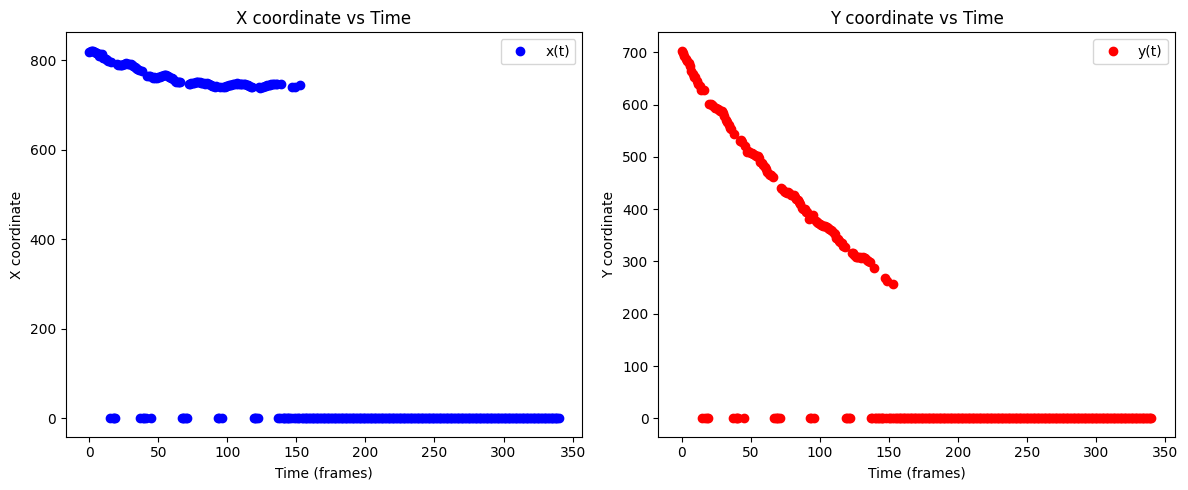

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(person.time_frames, person.x_skip, label="x(t)", color="blue", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("X coordinate")
plt.title("X coordinate vs Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(person.time_frames, person.y_skip, label="y(t)", color="red", marker='o', linestyle='')
plt.xlabel("Time (frames)")
plt.ylabel("Y coordinate")
plt.title("Y coordinate vs Time")
plt.legend()

plt.tight_layout()
plt.show()


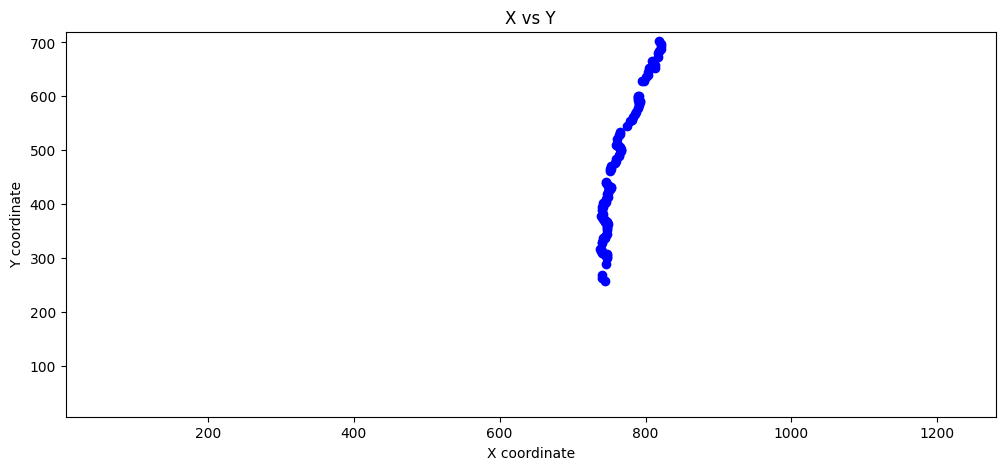

In [7]:
video = cv.VideoCapture("../videos/people2.mp4")
fps = video.get(cv.CAP_PROP_FPS)
status, img = video.read()
size=(img.shape[1], img.shape[0])

plt.figure(figsize=(12, 5))
plt.plot(person.x_skip, person.y_skip, label="x(t)", color="blue", marker='o', linestyle='')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("X vs Y")
plt.xlim(5, size[0])
plt.ylim(5, size[1])
plt.show()

In [8]:
time = [i for i in range(len(person.x))]

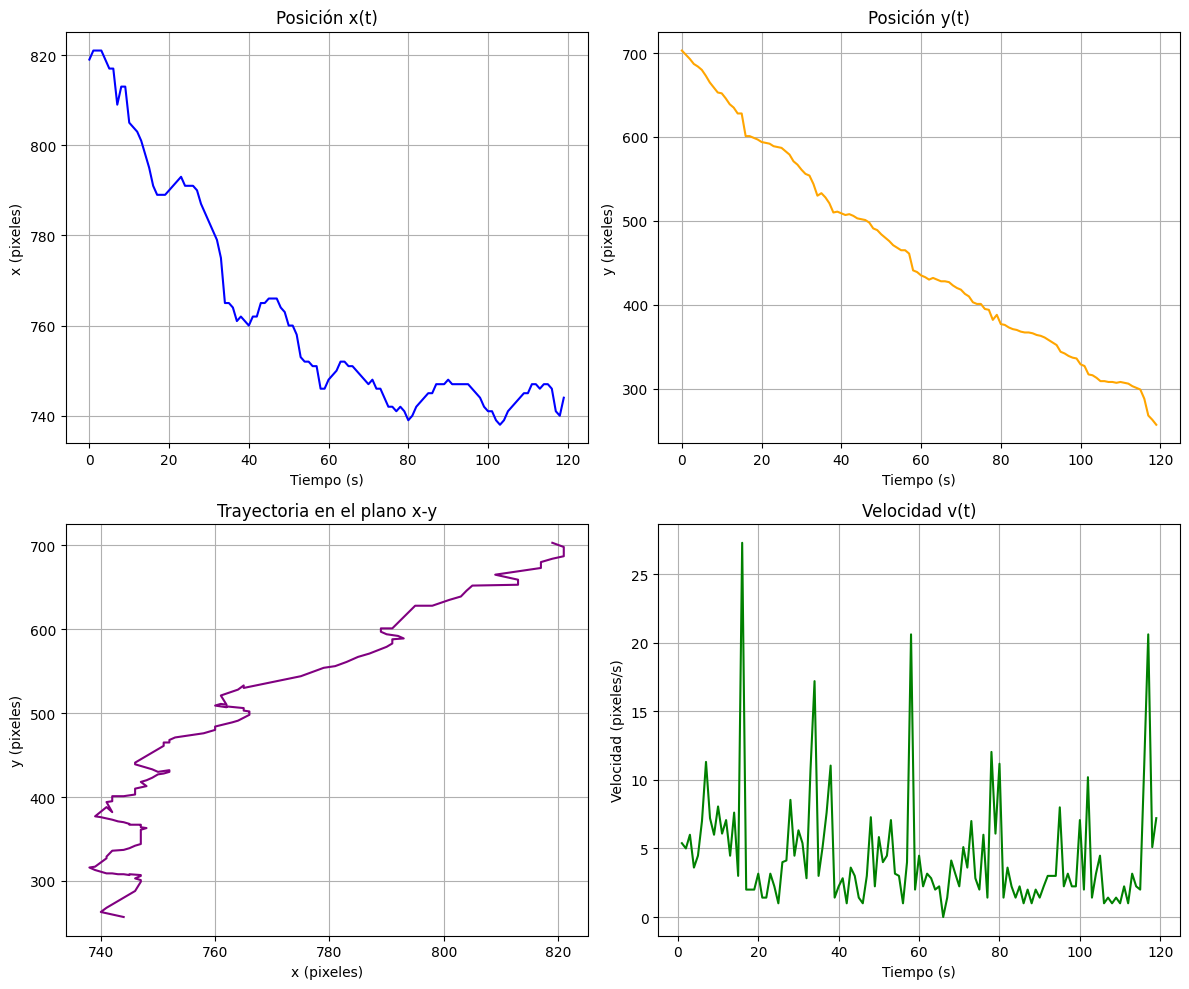

In [9]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(time, person.x, label="x(t)", color="blue")
plt.xlabel("Tiempo (s)")
plt.ylabel("x (pixeles)")
plt.title("Posición x(t)")
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, person.y, label="y(t)", color="orange")
plt.xlabel("Tiempo (s)")
plt.ylabel("y (pixeles)")
plt.title("Posición y(t)")
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(person.x, person.y, label="Trayectoria", color="purple")
plt.xlabel("x (pixeles)")
plt.ylabel("y (pixeles)")
plt.title("Trayectoria en el plano x-y")
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(time[1:], person.speeds, label="v(t)", color="green")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (pixeles/s)")
plt.title("Velocidad v(t)")
plt.grid()

plt.tight_layout()
plt.show()

## 2. Seguimiento de varias personas

In [10]:
video = cv.VideoCapture("../videos/people2.mp4")
fps = video.get(cv.CAP_PROP_FPS)

status, img = video.read()
size=(img.shape[1], img.shape[0])

fourcc = cv.VideoWriter_fourcc(*'DIVX')
video_out = cv.VideoWriter('../videos/yolo_todos.mp4', fourcc, 20.0, size)

model = YOLO('./models/yolo11x-pose.pt')


multi_tracker = MultiHandTracker(fps=fps)

while status:
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    detections = model(img)

    if len(detections) > 0:
        keypoints = detections[0].keypoints
        multi_tracker.update(keypoints)

    for hand in multi_tracker.tracked_hands:
        if len(hand.x) > 0:
            x, y = hand.x[-1], hand.y[-1]
            w, h = 10, 10
            cv.rectangle(img, (x - w // 2, y - h // 2), (x + w // 2, y + h // 2), (0, 255, 0))
        for j in range(1, len(hand.x)):
            if hand.x[j - 1] is not None and hand.x[j] is not None:
                cv.line(
                    img, 
                    (hand.x[j - 1], hand.y[j - 1]), 
                    (hand.x[j], hand.y[j]), 
                    (255, 0, 0), 
                    2
                )
    
    img_bgr = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    video_out.write(img_bgr)
    
    cv.imshow('Tracking', img)

    video_out.write(cv.cvtColor(img, cv.COLOR_RGB2BGR))
    
    status, img = video.read()
    if cv.waitKey(1) == 27:
        break
    
video.release()
video_out.release()
cv.destroyAllWindows()


0: 384x640 7 persons, 667.6ms
Speed: 0.0ms preprocess, 667.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 610.5ms
Speed: 1.0ms preprocess, 610.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 594.9ms
Speed: 0.5ms preprocess, 594.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 552.0ms
Speed: 2.0ms preprocess, 552.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 561.9ms
Speed: 0.0ms preprocess, 561.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 558.7ms
Speed: 0.0ms preprocess, 558.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 540.1ms
Speed: 0.0ms preprocess, 540.1ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 530.1ms
Speed: 1.0ms preprocess, 530.1ms inference, 0.0ms postprocess per 